## `blender_tissue_cartography` blender add-on

You can use `blender_tissue_cartography` in two forms:

1. The `blender_tissue_cartography` python library
2. The `blender_tissue_cartography` blender add-on

For sophisticated use cases (dynamic datasets, custom computer vision operation), or automated pipeline, use the python library. Most users though can start with the blender add-on, which allows you to carry out almost all steps of the tissue cartography pipeline within blender's graphical user interface.

The add-on has been tested with **blender version 4.3.2** - no guarantees for other versions!

### Installation

1. Download the add-on file [blender_addon.py](https://github.com/nikolas-claussen/blender-tissue-cartography/blob/main/blender_addon/blender_addon.py) from GitHub

2. [Install the add-on](https://docs.blender.org/manual/en/latest/editors/preferences/addons.html): Open Blender and click "Edit ->  Preferences -> Add-ons -> Add-on Settings -> Install from disk" and select `blender_tissue_cartography_addon.py`.

3. Restart Blender.

### Add-on user interface

The add-on can now be found under "Properties -> Scene":

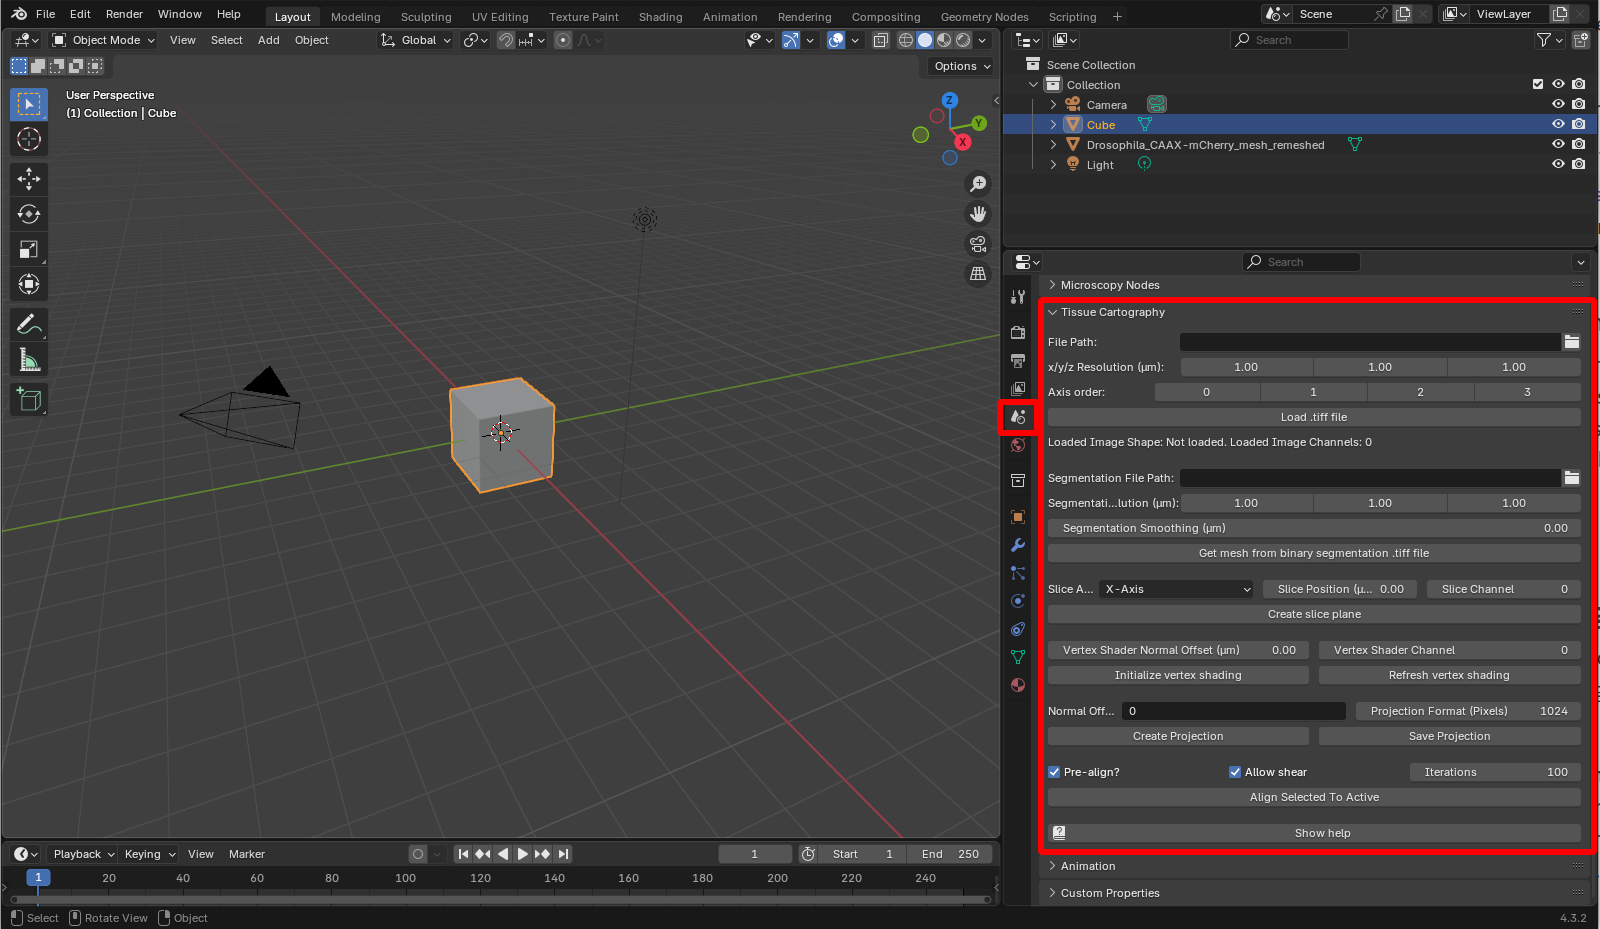

## Add-on workflow

Let's see the functionality of the add-on at work on an example dataset in the `nbs/Tutorials/addon_example` folder.

### Loading a volumetric dataset

We start by importing a volumetric dataset, in this case `nbs/Tutorials/addon_example/Drosophila_CAAX-mCherry.tif` ([download it here](https://github.com/nikolas-claussen/blender-tissue-cartography/tree/main/nbs/Tutorials/addon_example)). This is a light-sheet recording of the gastrulating _Drosophila_ embryo. You can inspect it in Fiji:

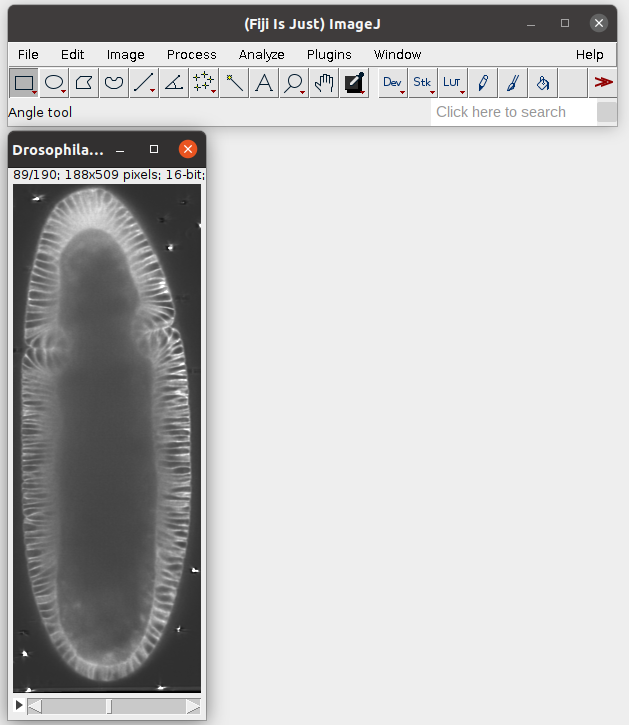

To load the dataset into Blender, click on "File Path" to select the `.tif` file, specify the resolution in microns/pixel for the $x,y,z$ axes (in this case, $1.05 \mu m$ for all axes), and click "Load .tiff file":

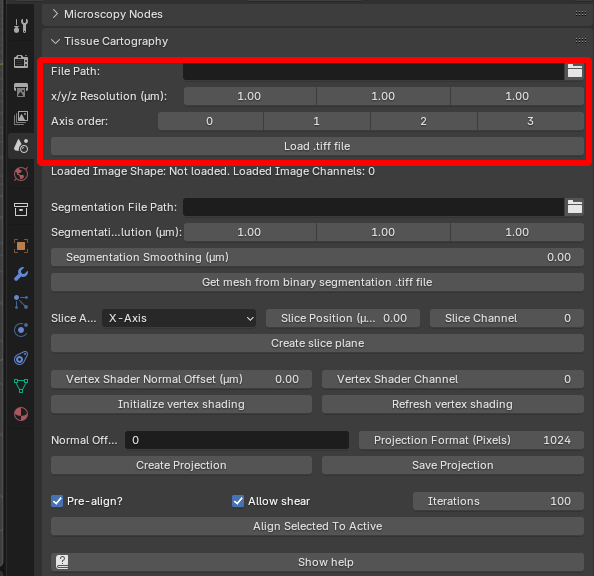

The loaded dataset is represented by a box mesh with dimensions equal to those of the image volume in microns. The add-on displays the shape (number of pixels along each axis) and the number of channels):

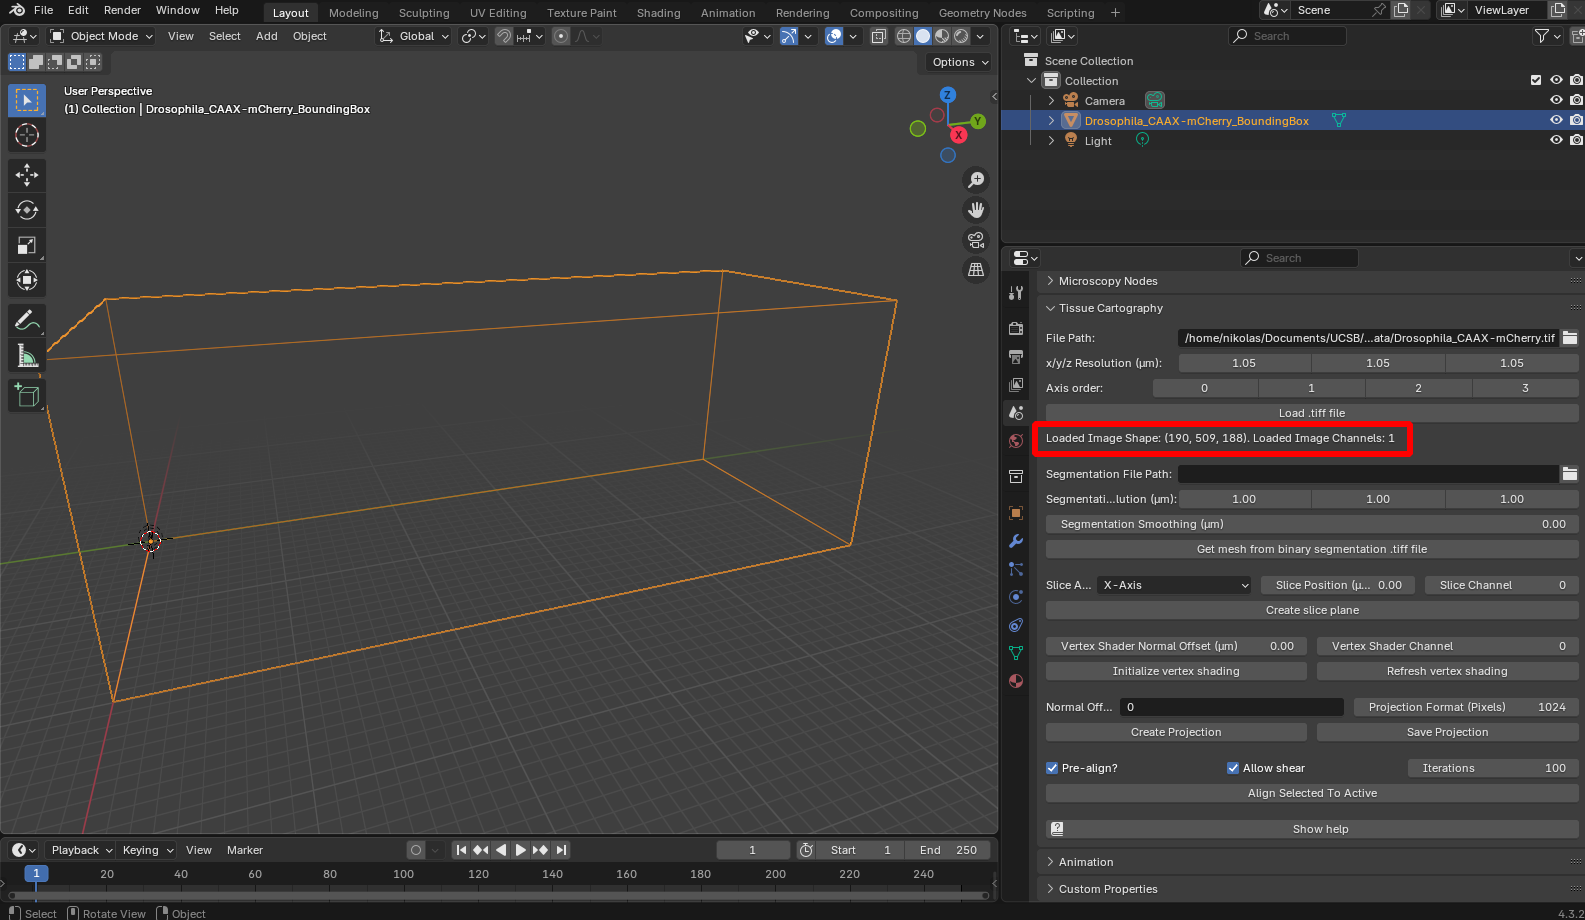

**Multi-channel data** The add-on supports both single-channel and multi-channel data (so `.tif` files with 3 or 4 dimensions). Time-series data is currently not supported.

**Axis order** A stupid but frequent problem in image processing is correctly interpreting the axes of a 3D, multichannel data. The add-on attemps to automatically recognize which axis is the channel axis and which one is $x,y,z$. If this goes wrong, you can use the "Axis order" input to permute the axes, and reload the `.tif` file. The channel axis should alway be the first. 




### Loading a mesh

Next, we need to obtain a mesh to represent the surface of interest (SOI) onto which we want to project our volumetric data. You have two options:

#### Loading a pre-computed mesh

If you already have a mesh, you can load it into blender via drag-and-drop. Try it with `nbs/Tutorials/addon_example/Drosophila_CAAX-mCherry_mesh_premade.obj`

**Mesh units** Importantly, the units of your mesh coordinates need to be in pixels!

**Mesh axis order** When importing a mesh into blender, you have to choose how blender interprets the $x,y,z$ axes. It is important to keep this choice consistent -  please select "Forward axis: Y" and "Up axis: Z"

#### Creating a mesh from a segmentation

Alternatively, you can create a mesh from a 3D segmentation, created for example by Ilastik (see Tutorial 1). This should be a single-channel volumetric `.tif`-file, with values close to 1 representing the inside, and close to 0 the outside of your sample.

An example segmentation is provided by `nbs/Tutorials/addon_example/Drosophila_CAAX-mCherry_subsampled-image_Probabilities.tif`
Here is what is looks like in Fiji:

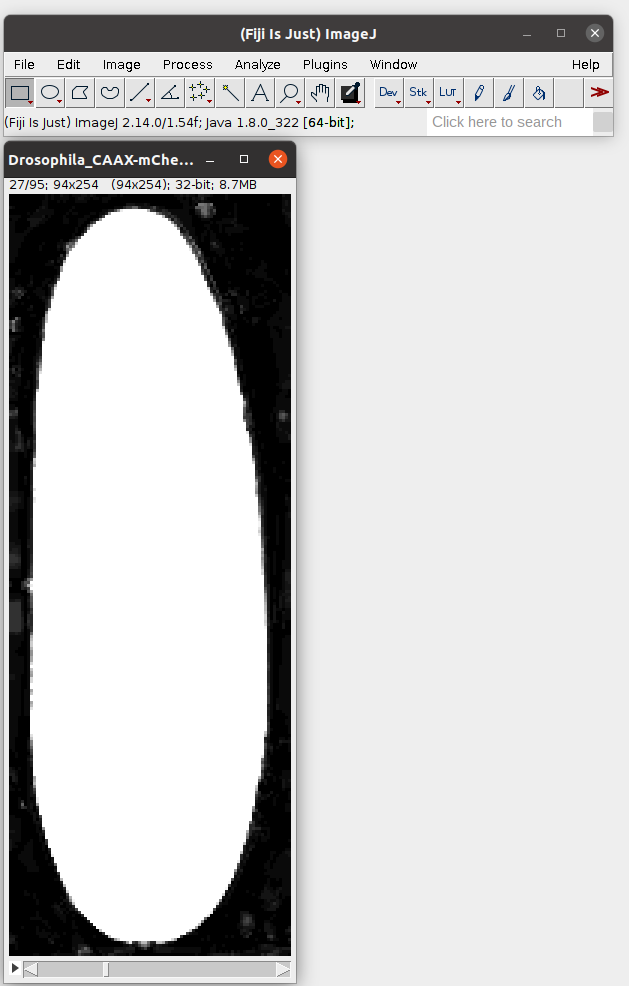

Click on "Segmentation File Path" to select this file, and specify the resolution (here $2.1\mu m$ for all axes). The "Segmentation smoothing" option allows creating a smooth mesh from the blocky/pixelized segmentation data:

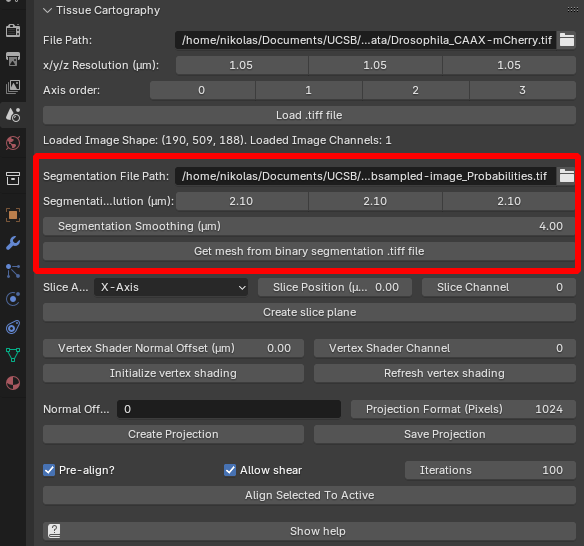

**Segmentation resolution** The resolution of your segmentation `.tif` file can be different from the image data. This is to allow you to downsample your image when you segment it (e.g. in Ilastik), which makes the segmentation often much faster.

After clicking "Get mesh from binary segmentation .tiff file", you should see a new mesh object in your scene:

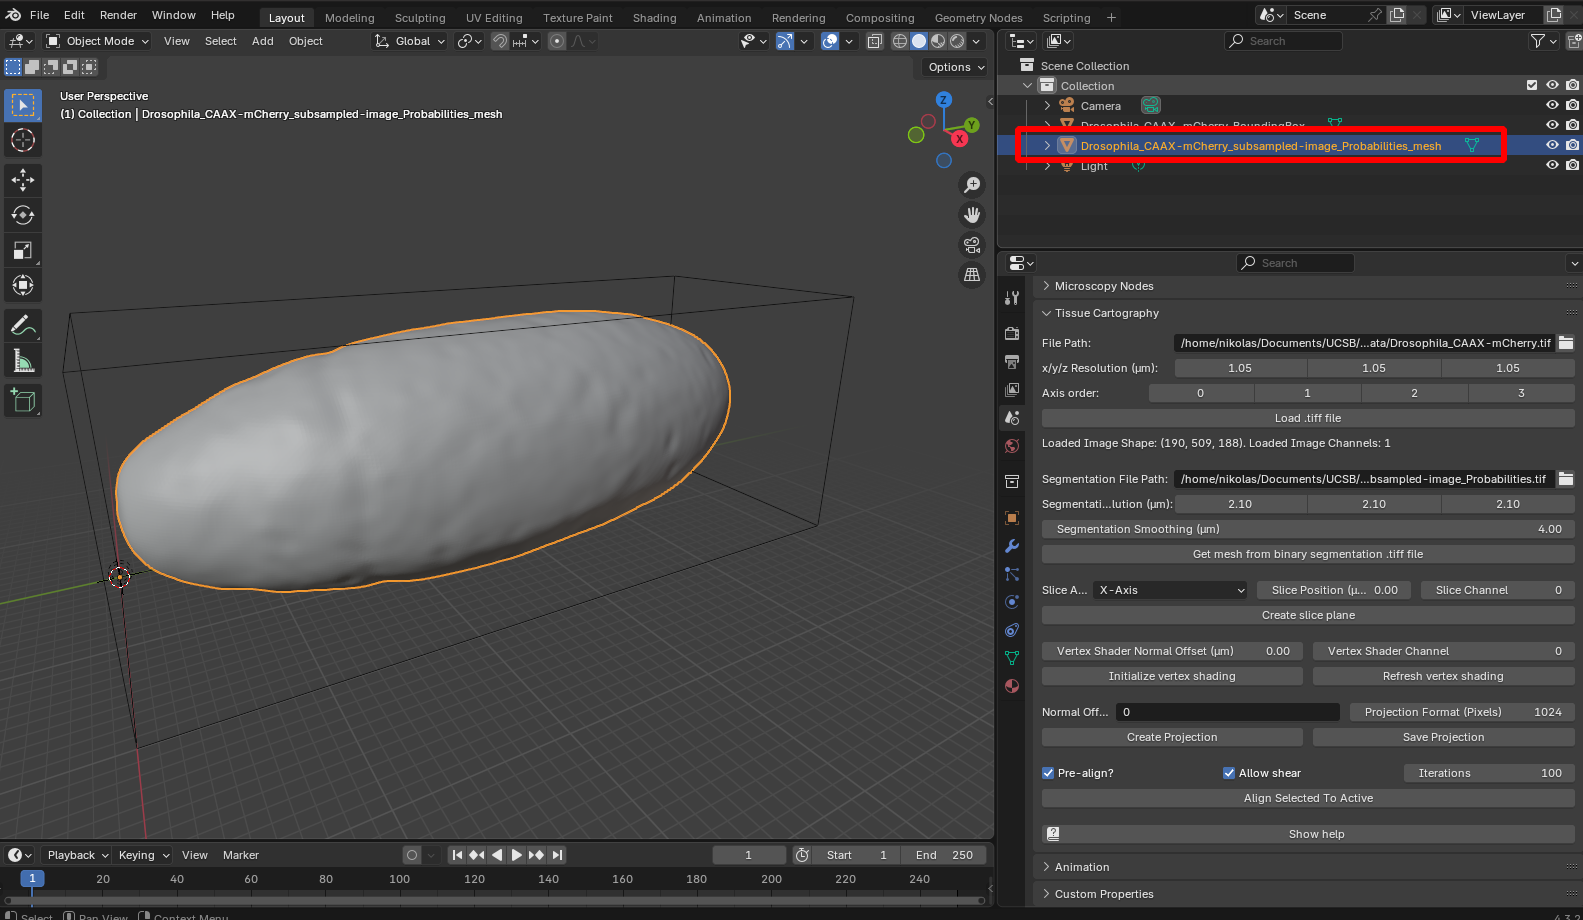

As you can see, the mesh of our surface lies nicely inside the bounding box of the image, indicating that they are correctly aligned.

### Data storage and representation in the `blender_tissue_cartography` add-on



### Visualize 3D data using orthogonal slices

To visualize the 3D data, we can create slices of it along the $x,y,z$ axes and load them into blender. To do this, select the bounding box representing the 3D data (it should be outlined in orange), chose an axis, a position along the axis, and a channel (here channel 0, since this is a single-channel dataset):

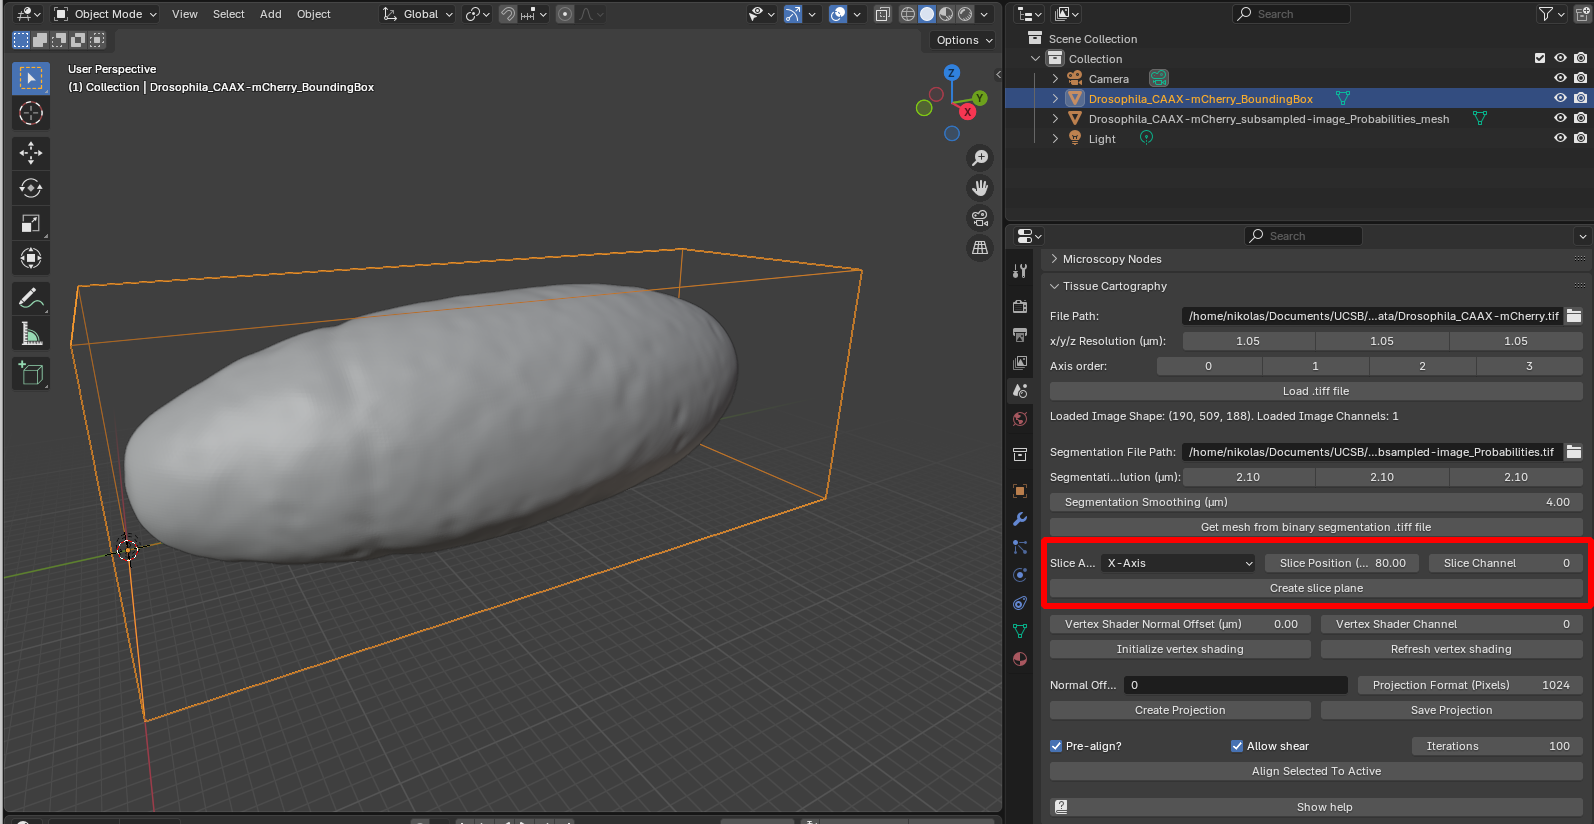

Click "create slice plane", and select "Material preview" to see the image texture on the slice:

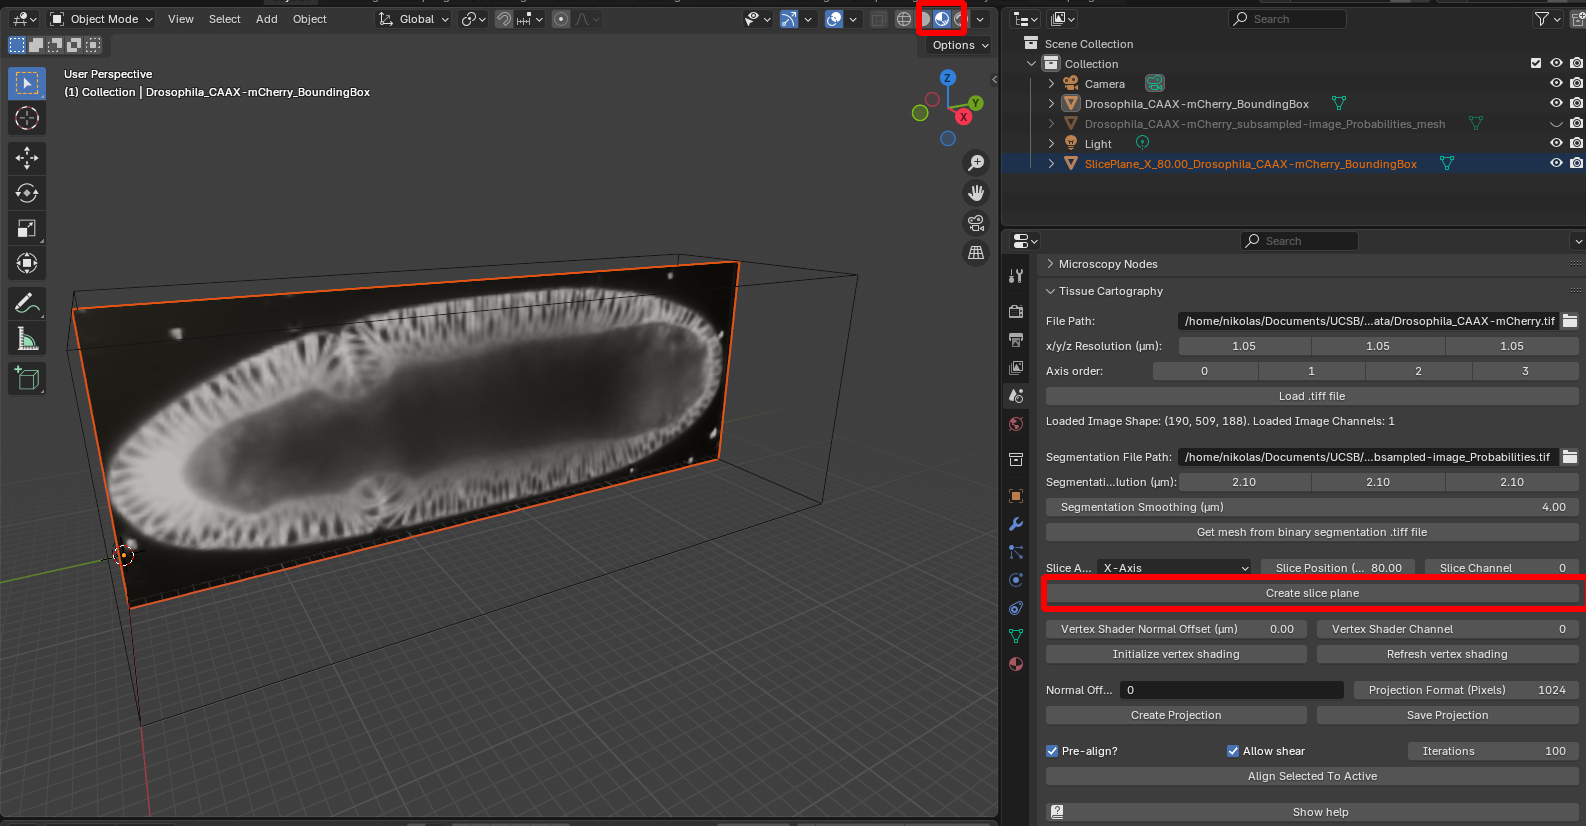

When toggling the visibility of the SOI mesh back on, we can see that it fits nicely along the contours of the 3D data:

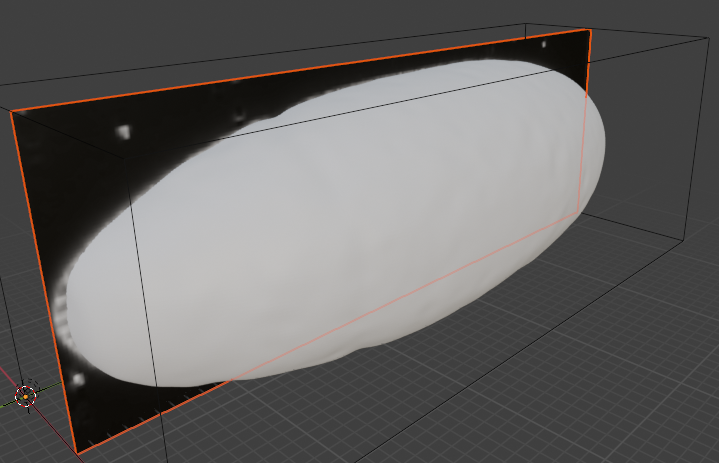

#### Volumetric rendering using MicroscopyNodes

`.tiff` files can also be rendered "volumetrically" in blderm using the [MicroscopyNodes](https://github.com/oanegros/MicroscopyNodes) plugin. This means each voxel will emit (or absorb) light, showing the full 3D-data instead of just a slice. However, this can be computationally expensive and may not give you a "helpful" view of the data if the 3D data is complex or shows a large object.\

***MicroscopyNodes coordinates** MicroscopyNodes scales and translates the `.tiff` data (scale 0.02 + centering in $x,y$). To overlay the volumetric object created by MicroscopyNodes with the `blender_tissue_cartography` representation, you need to undo this - go to "Object properties -> Transform":

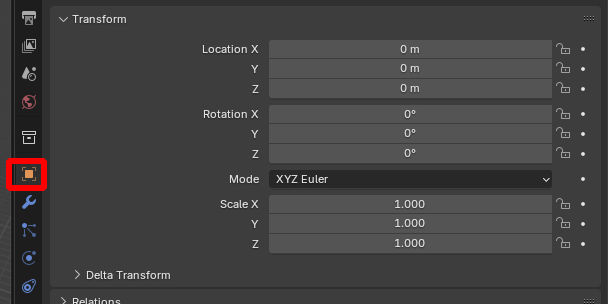



### Optional - remeshing

By selecting "Wireframe" shading, we can see that the mesh has a lot more vertices/detail than necessary to represent the shape of the embryo. For many downstream applications, it is useful to have a mesh with a lower resolution. Go to the "Sclupting workspace" and click on "Remesh", using whatever voxel-size you think is reasonable to control the mesh resolution:

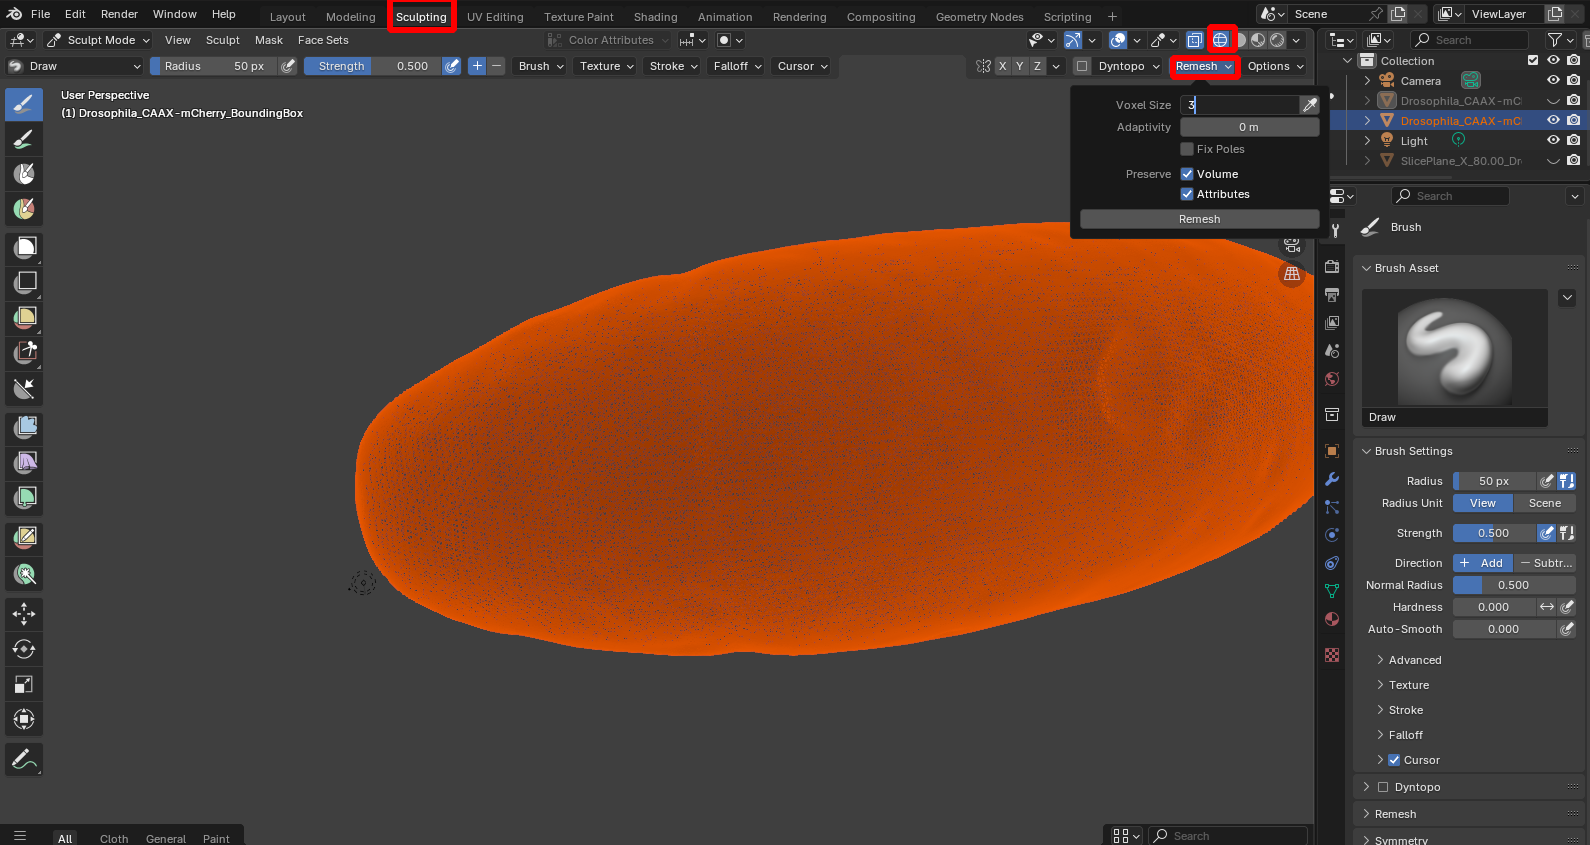

### Vertex shading

The add-on features two ways of projecting the 3D image data onto the SOI mesh. The first is called "Vertex shading", which looks up the image intensity at each vertex of the mesh and uses it to color the mesh. This does not require any UV map (cartographic projection of the mesh to the plane).

Select both the bounding box representing the volumetric image, and the mesh onto which you want to project the data. Select the channel you want. You can use the "Normal offset" button to look up the image intensity at the position of the vertex shifted inwards or outwards along the surface normal. After clicking "Initialize vertex shading" you should see the image projected onto the surface:

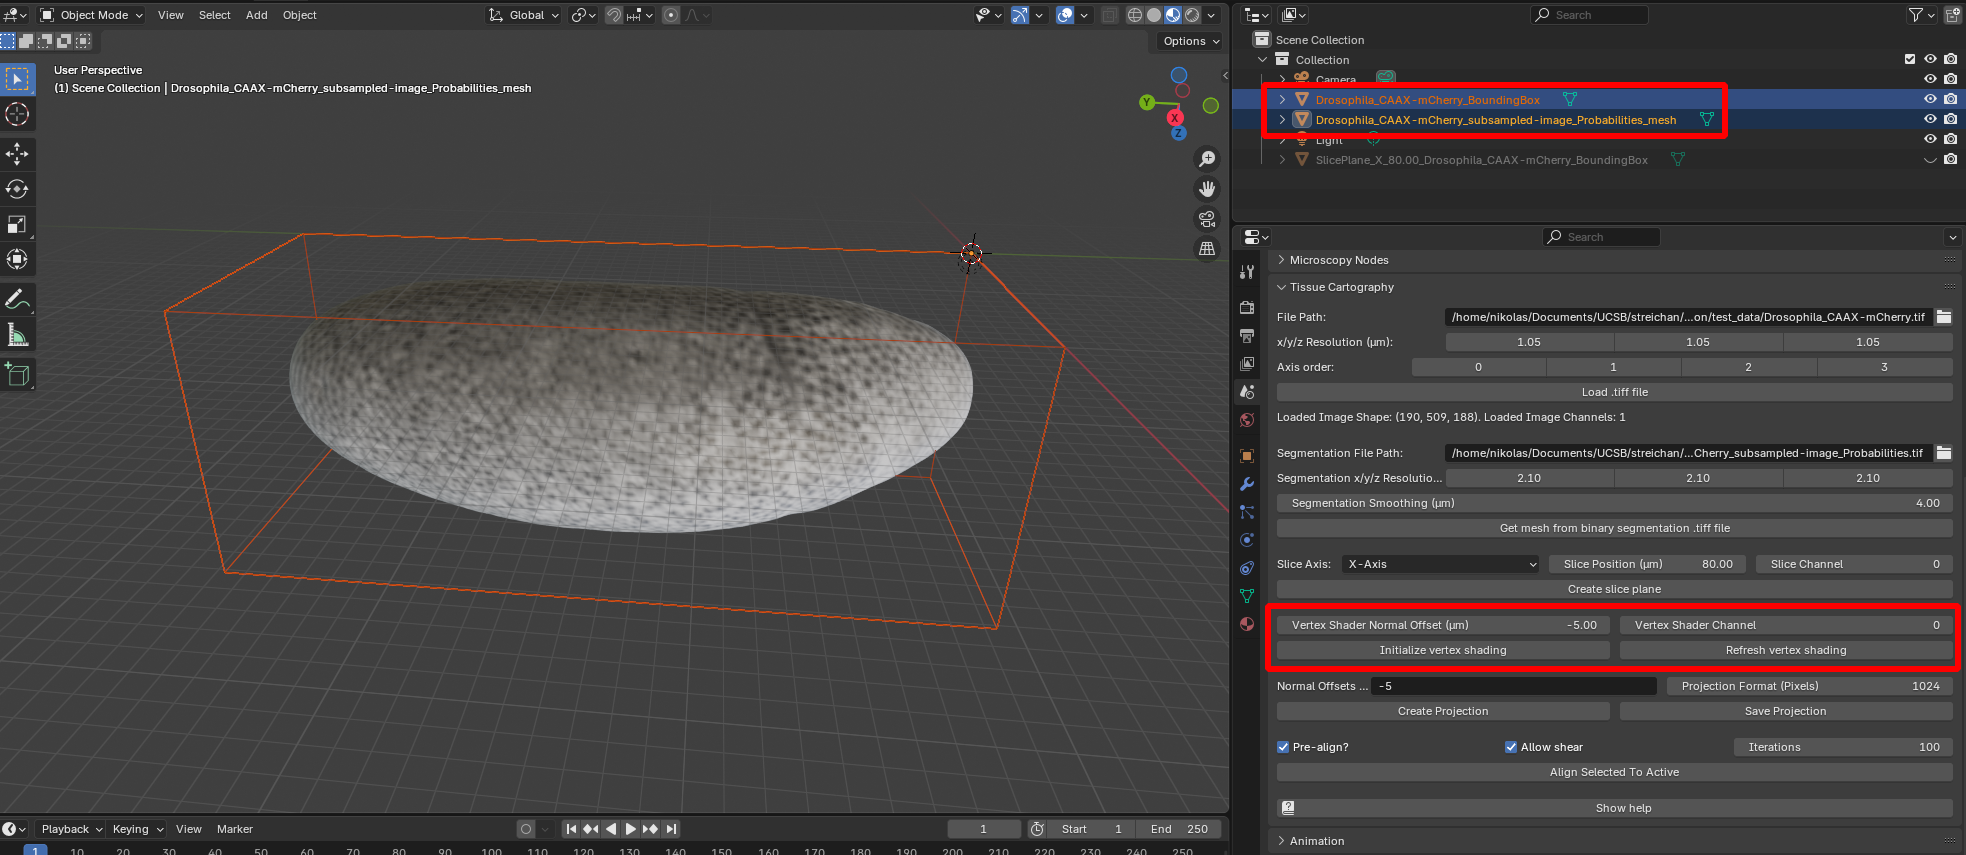

**Use case** Use this to get a quick idea of the image intensity of your mesh before creating your cartographic projection, or if you want to interactively sculpt the mesh (e.g. fixing holes, or deforming the mesh so it matches the 3D data better). Use the "Refresh vertex shading" button to update the vertex colors every time you sculpt.

**Resolution** You will need a relatively high-resolution mesh (with many vertices), or the vertex shader will look blurry. The resolution of cartographic projections (see below) on the other hand is _independent_ of the mesh resolution - you can get a high-resolution projection with a coarse mesh.


#### Fine-tuning the vertex shading

The new texture of the mesh is controlled by a "Material" which you can edit in the "Shading" workspace for fine-tuning (e.g. adjusting brightness or contrast):

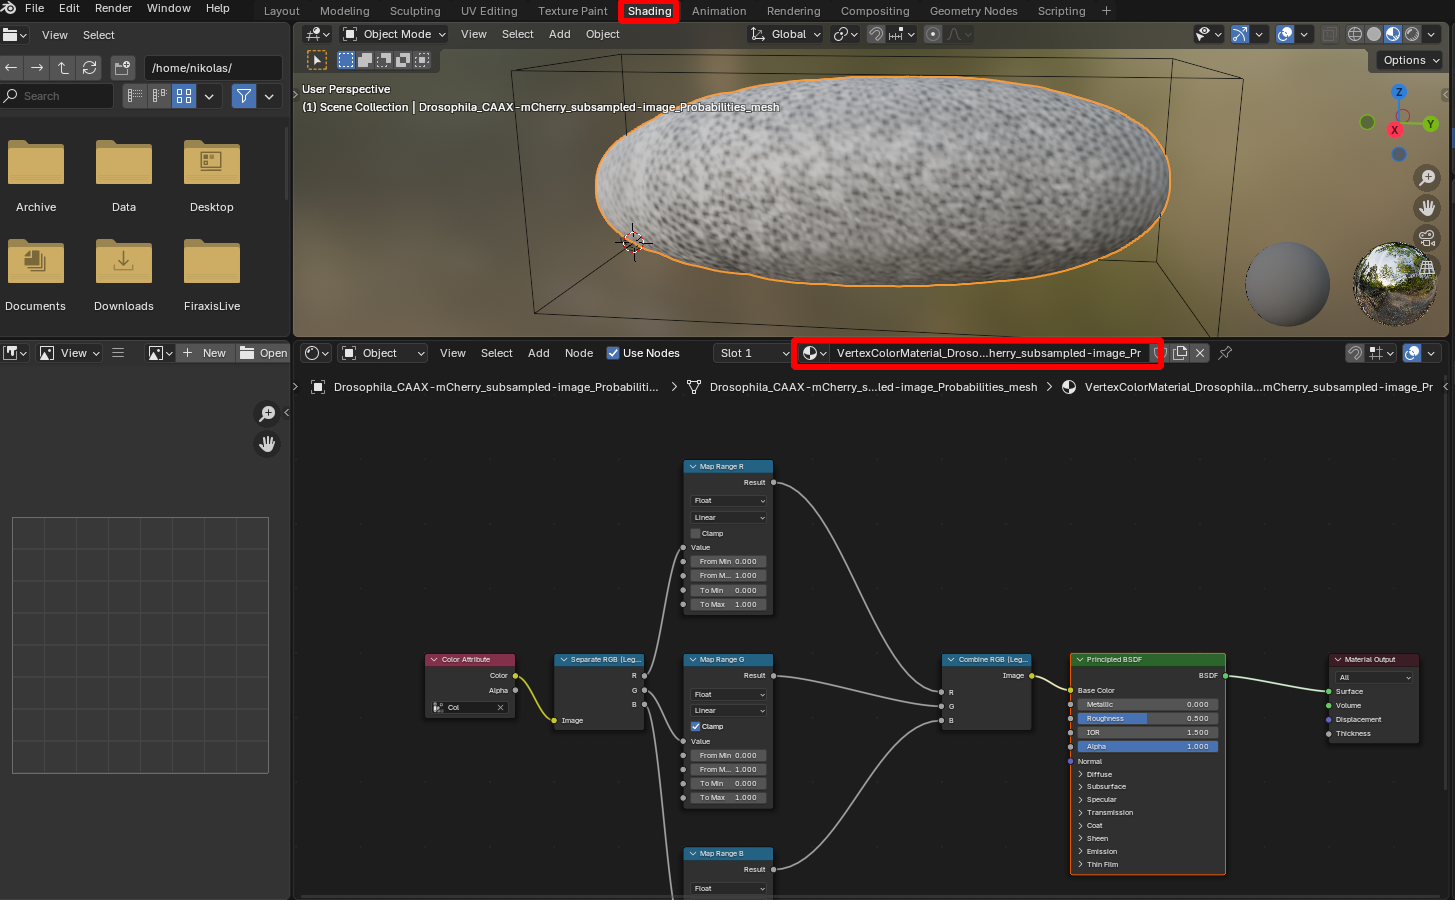


### Cartographic projection

Vertex shading can give you a first idea of the image intensity projected onto the mesh, but it has several disadvantages:

1. The projected data is saved as one intensity per vertex, instead of as continuous 2D image, which makes quantitative image analysis (cell segmentation, for example) very difficult
2. The mesh resoution controls the image resolution so you need a very dense mesh (which is inefficient)
3. You can only see one part of the 3D shape at a time, which makes visualization harder

Instead, we now compute a cartographic projection of the data, which unwraps the mesh to a plane (much like a map of the globe) and projects the 3D image data to a genuine 2D image.


#### Unwrap mesh using UV editor

We first need to unwrap our mesh. This can be done in the "UV Editing" workspace (see previous tutorial). Here, we use the fully automatic "Smart UV Project" algorithm ("UV -> Unwrap -> Smart UV project"):

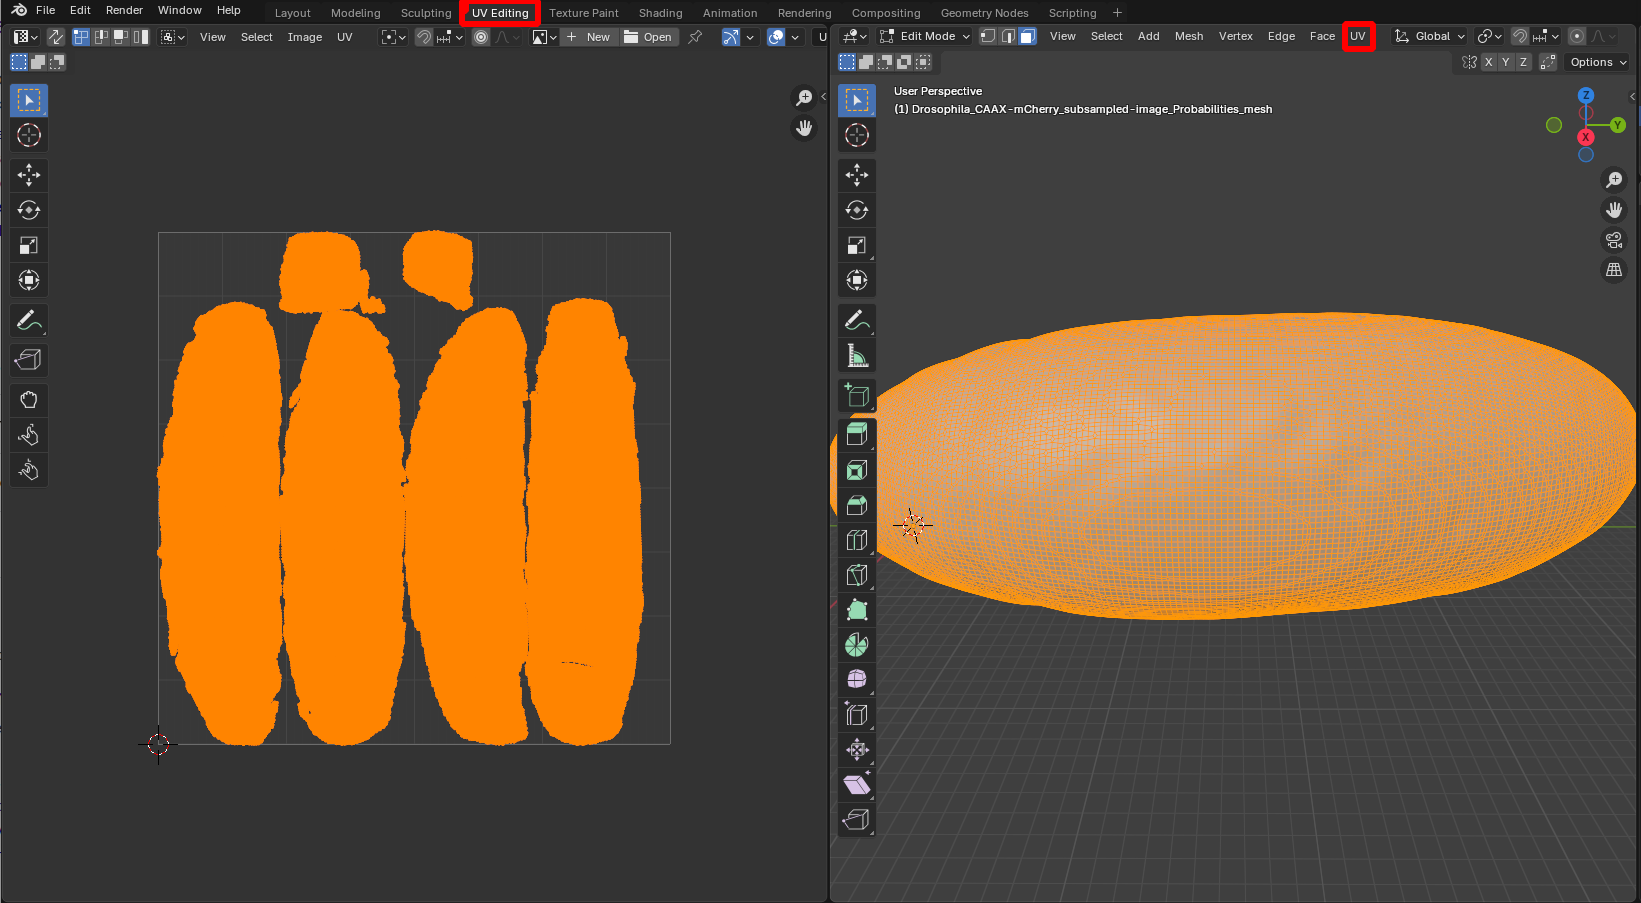

See also tutorials 2 and 4!

**Self-intersections** It is important to try to unwrap the mesh while avoiding self-intersection (where the mesh is folded onto itself in 2D). This is bad because the multiple 3D positions are mapped to the same cartographic location. For example, if you use the "project from view on the example UV cube:

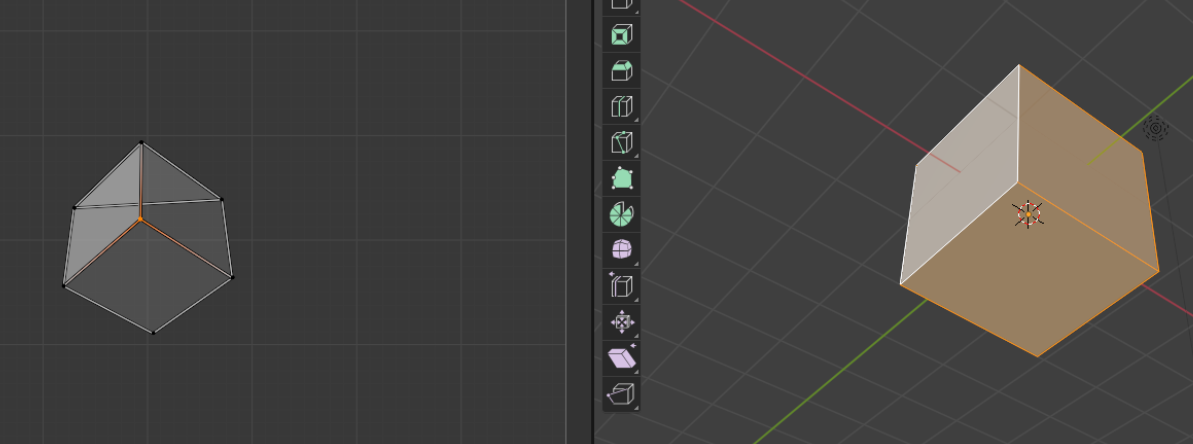


#### Compute a cartographic projection

Now we are ready to compute a cartographic projection using the add-on. The add-on can compute _multilayer projections_ where each layer shows the image intensity at a given distance from the surface of interest inwards or outwards along the surface normal (a bit like the layers of an onion). You specify the layers you want as a comma-separated list using the "Normal offsets" field. Positive and negative values represent an outwards, respectively inwards shift (in microns).

The projected data will always be a square image, covering the _UV square_ (the 2D region into which we unwrapped our mesh in the preceding step). The number of pixels of the image is controlled by the "Projection Format" field. 
Select _both_ the mesh and the 3D data set, and click "Create Projection":

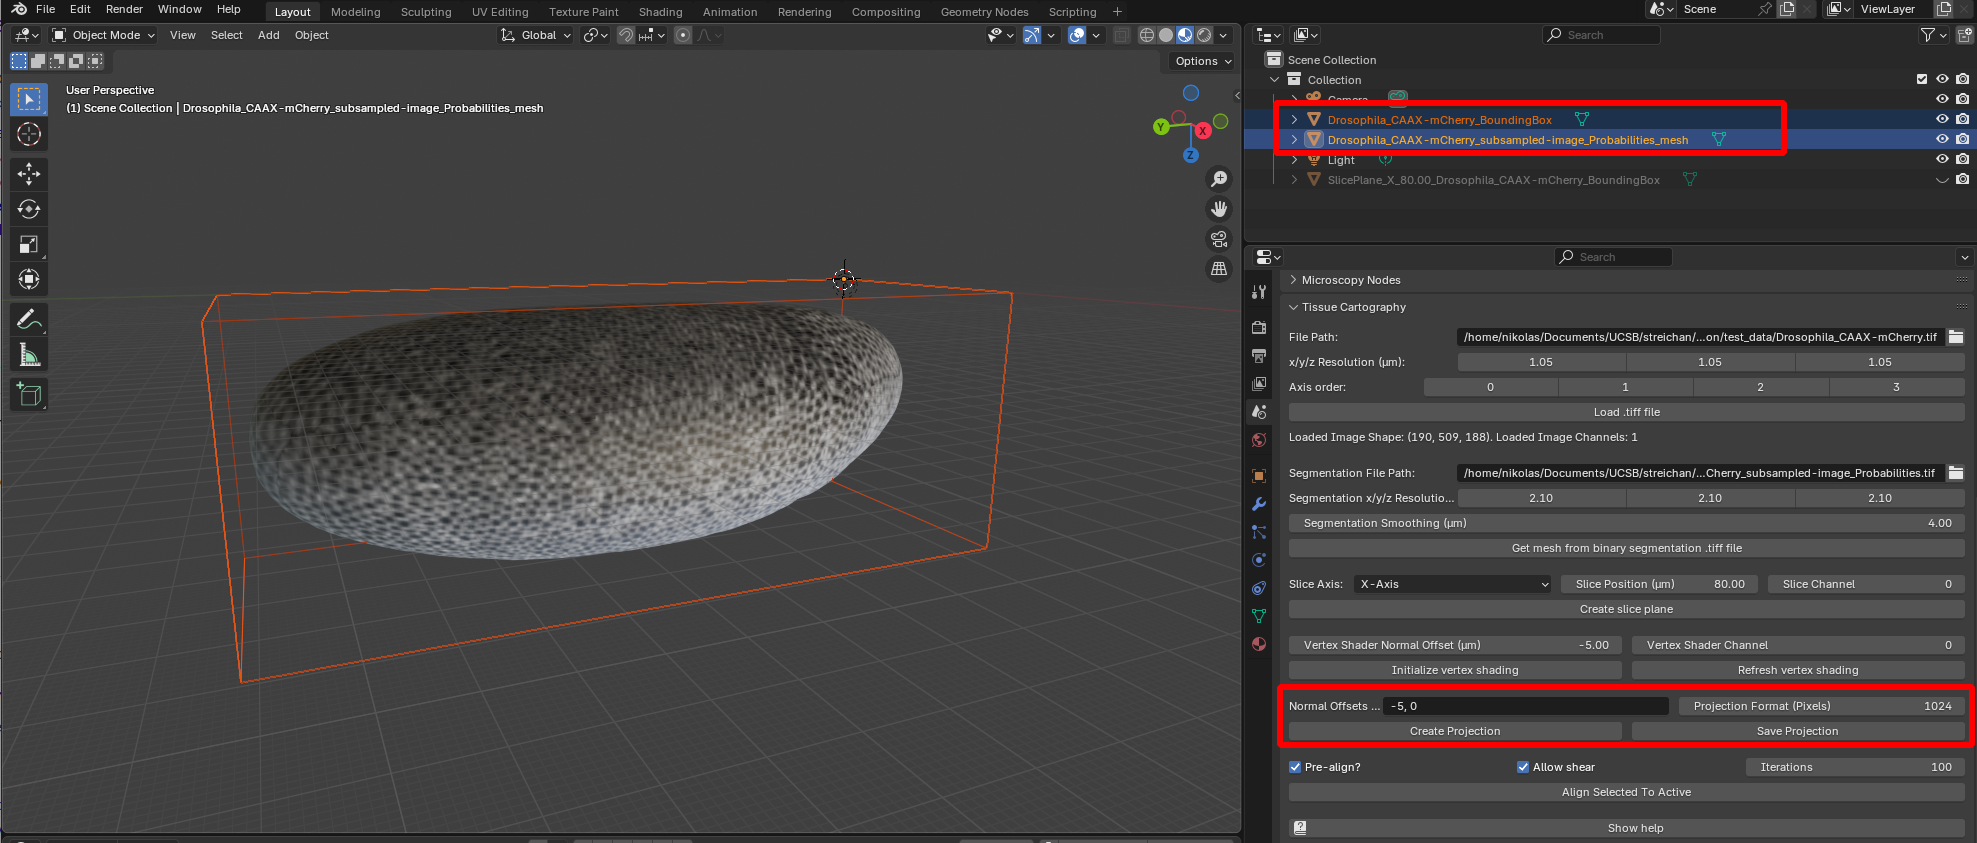

The projected data just created is now associated with the mesh, and can be visualized in blender thanks to a newly created "Material". You can check it out in the shading tab. You can look at the 2D projected image on the left. On the bottom, you can modify the connections of the nodes to determine, for instance, which layer of the multi-layer projection is shown:

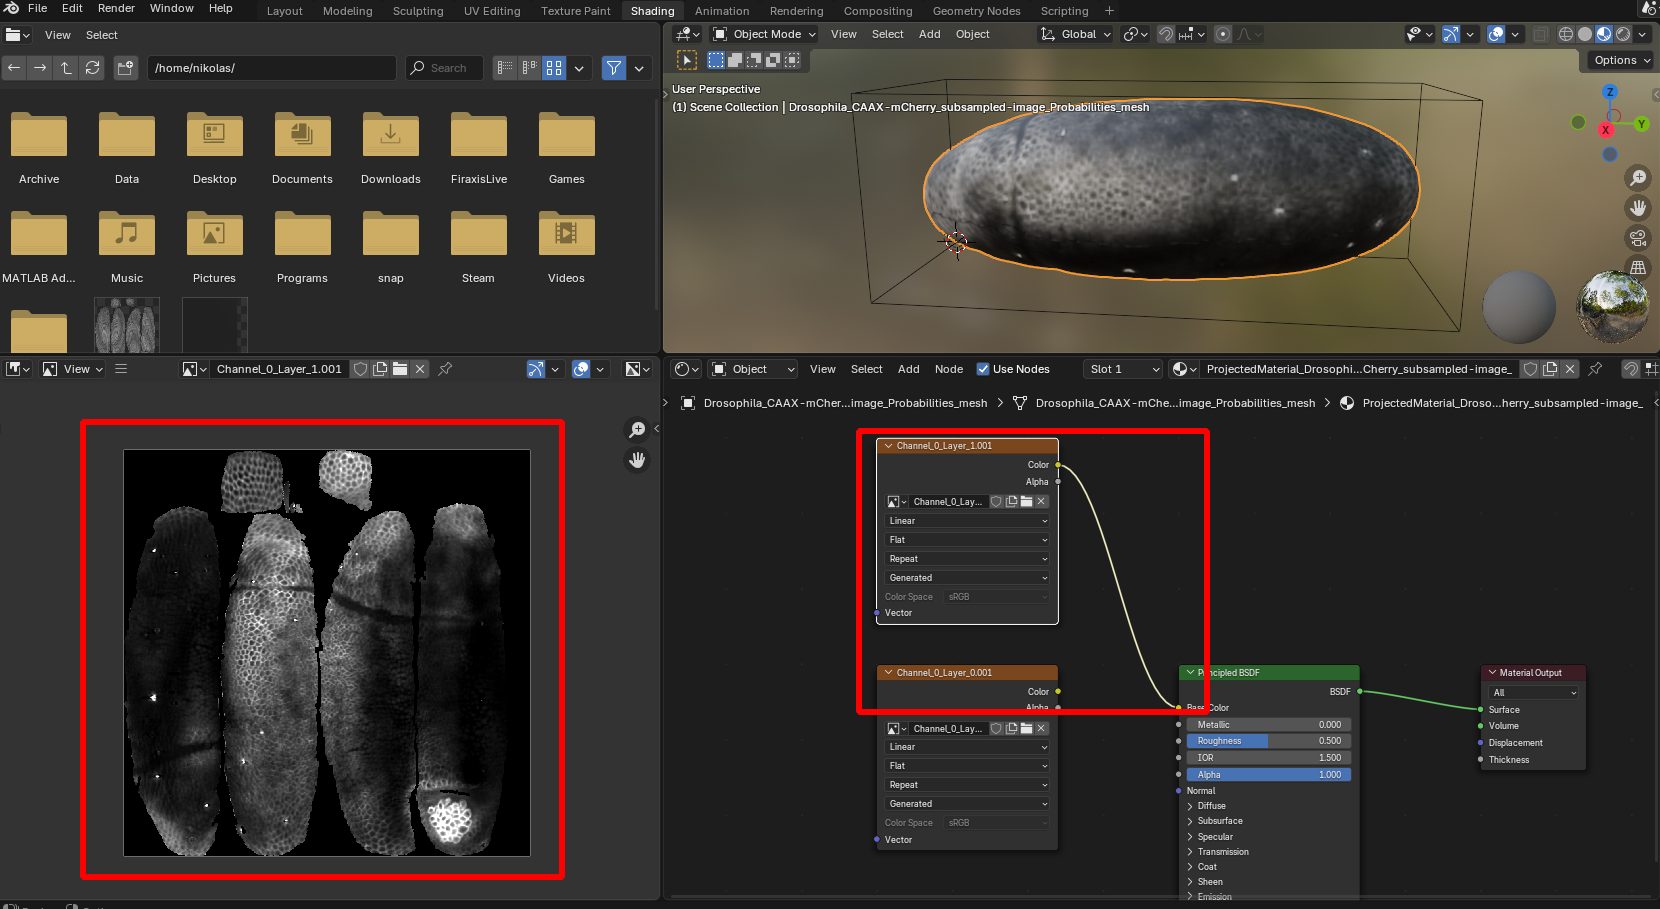

#### Save a cartographic projection

Finally, we can save the cartographic projection to disk. Select the mesh of which you want to save the projection, and click "Save projection":

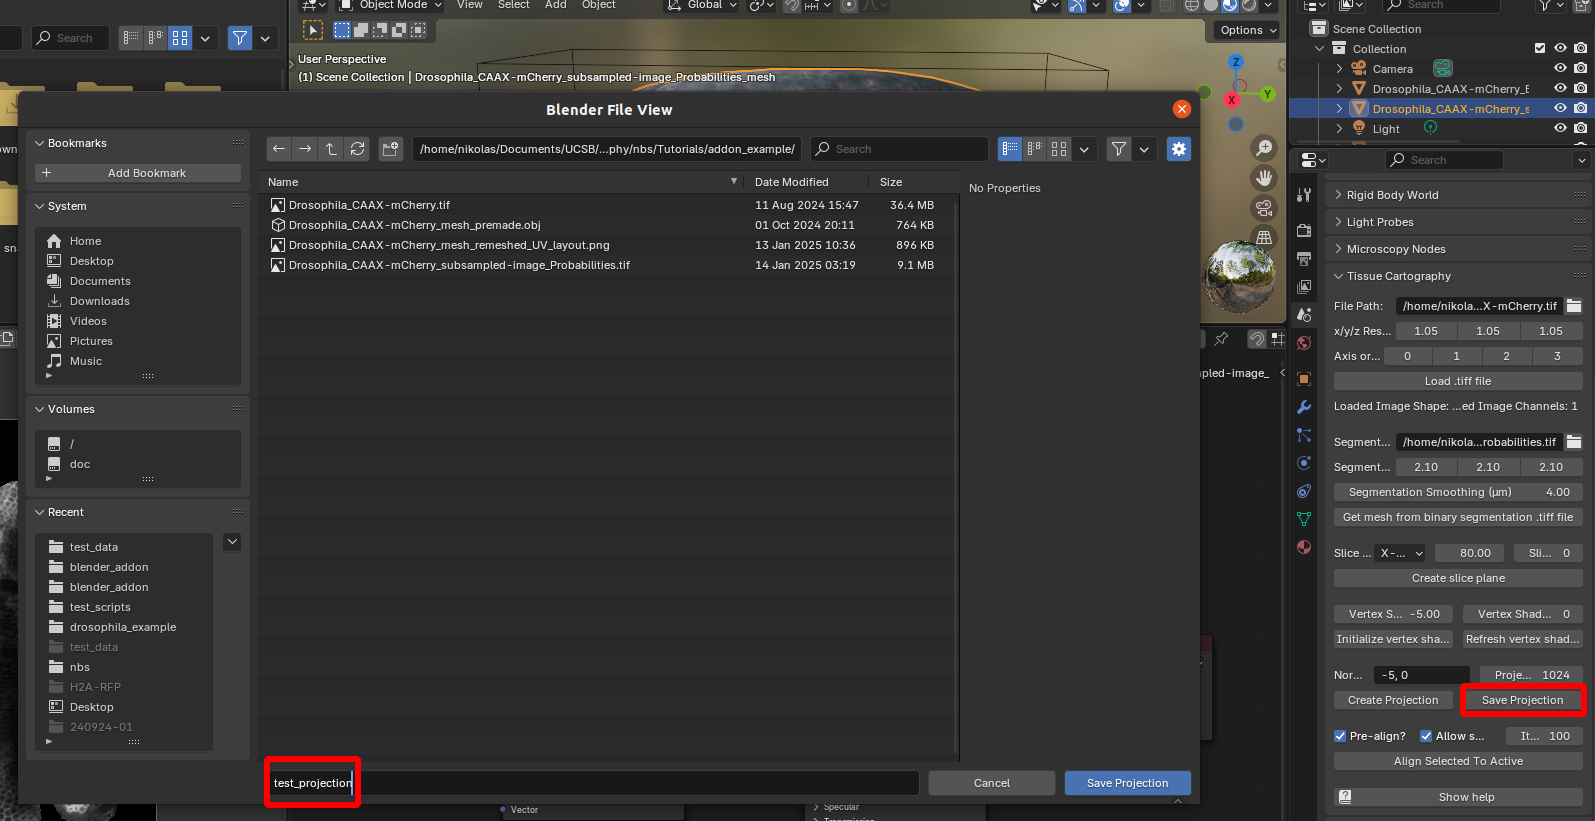


### Annotating data in blender

### Consistent cartographic projections across multiple recording